# Sprint 機械学習スクラッチ 決定木

## 決定木スクラッチ
分類のための決定木のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

決定木の学習には何回まで条件分岐を繰り返すかを表す（最大の）深さというハイパーパラメータが登場しますが、深さ1の実装を必須課題とします。深さが2以上のものはアドバンス課題とします。

学習の仕方には様々な方法がありますが、ここではscikit-learnでも使用されているCART法をベースとした実装を行います。この方法では学習の複雑さを減らすために、分岐は2つに分かれるのみになります。

分割の条件を学習で求める
学習によって、ノードをどういった条件で分割すると、うまく分けられるかということを求めます。

うまく分けられていることを判定するためにノードに対してジニ不純度と情報利得という値を計算します。

In [20]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [21]:
class ScratchDecisionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Attributes
    ----------
    self.threshold : number
      決定木の閾値
    self.threshold_id : 次の形のndarray, shape (1, 1) 
      閾値のインデックス
    self.leaf_l : number or obj
      左側の葉ノードの推定ラベル
    self.leaf_r : number or obj
      右側の葉ノードの推定ラベル
    """
    
    def __init__(self):
        self.threshold = None
        self.threshold_id = None
        self.leaf_l = None
        self.leaf_r = None
        
        
    def gini_impurity(data):
        """
        ジニ不純度を計算する

        Parameters
        ----------
        data : 次の形のndarray, shape (n_samples,)
    　　　　目的変数の配列

        Returns
        -------
          float
          計算されたジニ不純度

        """
        gi = 0

        labels, count = np.unique(data, return_counts=True)

        for i in range(len(labels)):
            gi += (count[i]/len(data))**2

        return 1 - gi
    
    
    def information_gain(node_root, node_l, node_r):
        """
        利得情報を計算する

        Parameters
        ----------
        node_root : 次の形のndarray, shape (n_samples,)
          分割前の目的変数
        node_l : 次の形のndarray, shape (n_samples,)
          分割後に左ノードに格納された目的変数
        node_r : 次の形のndarray, shape (n_samples,)
          分割後に右ノードに格納された目的変数
          
        Returns
        -------
        ig : float
          計算された利得情報

        """
        ig = gini_impurity(node_root) \
             - len(node_l)/len(node_root) * gini_impurity(node_l) \
             - len(node_r)/len(node_root) * gini_impurity(node_r)

        return ig
    
    
    def fit(self, X, y):
        """
        決定木分類器を学習する
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """
            
        node_root = y
    
        ig = np.empty(X.shape)

        # 各特徴量に対して利得情報を計算
        for j in range(len(X[0])):
            # 各サンプルを決定境界とした場合の利得情報を計算
            for i in range(len(X)):
                threshold = X[i][j]
                node_l = y[X[:,j] < threshold]
                node_r = y[X[:,j] >= threshold]

                ig[i][j] = information_gain(node_root, node_l, node_r)

        # 最大利得情報のインデックスを２次元で抽出
        self.threshold_id = np.unravel_index(np.argmax(ig), ig.shape)
        self.threshold = X[self.threshold_id]

        self.leaf_l = stats.mode(y[X[:, self.threshold_id[1]] < self.threshold])[0]
        self.leaf_r = stats.mode(y[X[:, self.threshold_id[1]] >= self.threshold])[0]
    
    
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
            
        Returns
        -------
        pred : 次の形のndarray, shape (n_samples, )
          推定された値
        
        """
        
        pred = np.where(X[:, self.threshold_id[1]] < self.threshold, self.leaf_l, self.leaf_r)
    
   
        return pred

## 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード$t$に対するジニ不純度$I(t)$は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。

$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$
まずは簡単な例を作り、手計算と関数の結果を比較してください。

《例》

- クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500
- クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667
- クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480
- クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000

In [22]:
def gini_impurity(data):
    """
    ジニ不純度を計算する

    Parameters
    ----------
    data : 次の形のndarray, shape (n_samples,)
    目的変数の配列

    Returns
    -------
      float
      計算されたジニ不純度

    """
    gi = 0
    
    labels, count = np.unique(data, return_counts=True)
    
    for i in range(len(labels)):
        gi += (count[i]/len(data))**2
    
    return 1 - gi

In [23]:
data1 = np.concatenate((np.zeros(15), np.ones(15)))
data2 = np.concatenate((np.concatenate((np.zeros(15), np.ones(15))),
                        np.full(15, 2)))

print(gini_impurity(data1))
print(gini_impurity(data2))

0.5
0.6666666666666667


## 【問題2】情報利得を求める関数
次に、ノード間の情報利得を計算する関数を作成してください。問題1で作成したジニ不純度$I(t)$を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。

ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。

$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

In [24]:
def information_gain(node_root, node_l, node_r):
    """
    利得情報を計算する

    Parameters
    ----------
    node_root : 次の形のndarray, shape (n_samples,)
      分割前の目的変数
    node_l : 次の形のndarray, shape (n_samples,)
      分割後に左ノードに格納された目的変数
    node_r : 次の形のndarray, shape (n_samples,)
      分割後に右ノードに格納された目的変数

    Returns
    -------
    ig : float
      計算された利得情報

    """
    ig = gini_impurity(node_root) \
         - len(node_l)/len(node_root) * gini_impurity(node_l) \
         - len(node_r)/len(node_root) * gini_impurity(node_r)
    
    return ig

In [25]:
node_root = np.concatenate((np.zeros(30), np.ones(35)))
node_l = np.concatenate((np.zeros(10), np.ones(30)))
node_r = np.concatenate((np.zeros(20), np.ones(5)))

print(information_gain(node_root, node_l, node_r))

0.14319526627218937


## 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。

クラスが混ざらない不純度が0のノード、または指定された深さのノードが葉ノードとなります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。


《組み合わせの取り方》
全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。

他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。


《補足》
問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度$I(p)$は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

In [26]:
def fit(X, y):
    """
    決定木分類器を学習する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量
    y : 次の形のndarray, shape (n_samples, )
        訓練データの正解値
    """
    
    node_root = y
    
    ig = np.empty(X.shape)
    
    # 各特徴量に対して利得情報を計算
    for j in range(len(X[0])):
        # 各サンプルを決定境界とした場合の利得情報を計算
        for i in range(len(X)):
            threshold = X[i][j]
            node_l = y[X[:,j] < threshold]
            node_r = y[X[:,j] >= threshold]

            ig[i][j] = information_gain(node_root, node_l, node_r)
        
    # 最大利得情報のインデックスを２次元で抽出
    threshold_id = np.unravel_index(np.argmax(ig), ig.shape)
    threshold = X[threshold_id]
    
    leaf_l = stats.mode(y[X[:, threshold_id[1]] < threshold])[0]
    leaf_r = stats.mode(y[X[:, threshold_id[1]] >= threshold])[0]
  
    return threshold_id, threshold

## 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。

入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [27]:
def predict(X):
    """
    決定木分類器を使いラベルを推定する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
        訓練データの特徴量

    Returns
    -------
    pred : 次の形のndarray, shape (n_samples, )
      推定された値

    """
    
    pred = np.where(X < threshold, leaf_l, leaf_r)
    
    return pred

## 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [28]:
# シンプルデータセット2作成コード

X = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
           [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
           [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
           [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
           [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
           [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
           [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
           [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
           [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
           [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
           [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
           [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
           [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
           [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
           [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
           [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
           [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
           [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
           [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
           [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [29]:
# sklearnの決定木を読み込み
from sklearn.tree import DecisionTreeClassifier

# 評価指標の読み込みおよび関数化
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def get_scores(y_true, y_pred):
    print("-"*20)
    print("正解率：{:.2f}".format(accuracy_score(y_true, y_pred)))
    print("適合率：{:.2f}".format(precision_score(y_true, y_pred)))
    print("再現率：{:.2f}".format(recall_score(y_true, y_pred)))
    print("F1値：{:.2f}".format(f1_score(y_true, y_pred)))
    print("-"*20)
    print("\n")

In [30]:
# データの分割（今回は7：3の割合）
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

print(X_train.shape)
print(y_train.shape)

(30, 2)
(30,)


In [31]:
# スクラッチモデルの学習と推定
scratch_tree = ScratchDecisionTreeClassifierDepth1()

scratch_tree.fit(X_train, y_train)

scratch_pred = scratch_tree.predict(X_test)

print("スクラッチモデルの成績")
get_scores(y_test, scratch_pred)

# sklearnモデルの学習と推定
sk_tree = DecisionTreeClassifier(max_depth=1)

sk_tree.fit(X_train, y_train)

sk_pred = sk_tree.predict(X_test)

print("sklearnモデルの成績")
get_scores(y_test, sk_pred)

スクラッチモデルの成績
--------------------
正解率：0.60
適合率：0.67
再現率：0.40
F1値：0.50
--------------------


sklearnモデルの成績
--------------------
正解率：0.60
適合率：0.67
再現率：0.40
F1値：0.50
--------------------




## 【問題6】決定領域の可視化
決定領域を可視化してください。

In [32]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, target_names, step=0.01, title='decision region', xlabel='xlabel',
                    ylabel='ylabel'):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

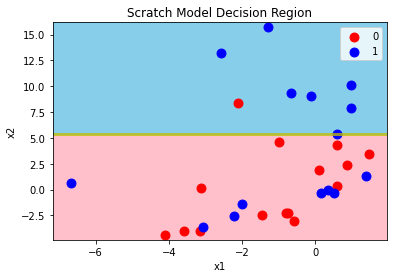

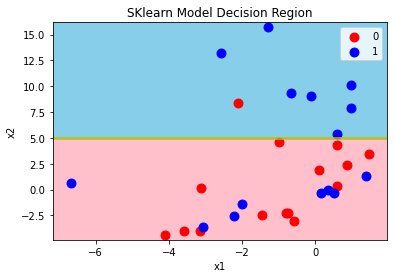

In [33]:
# スクラッチモデルの可視化
decision_region(X_train, y_train, scratch_tree, title='Scratch Model Decision Region',
                xlabel='x1', ylabel='x2', target_names=['0', '1'])

# sklearnモデルの可視化
decision_region(X_train, y_train, sk_tree, title='SKlearn Model Decision Region',
                xlabel='x1', ylabel='x2', target_names=['0', '1'])